# Predicting Sales Prices

 ## Dataset Attributes

 The dataset contains information about houses in Ames, Iowa. The data was collected by the Ames City Assessor’s Office describing 2930 property sales which occurred in Ames, Iowa between 2006 and 2010. The dataset, containing 81 variables, was compiled and published by De Cock in 2011.

 Some of the variables contained in the original dataset have been removed from the the dataset provided to you.
 The dataset provided to you contains the following variables:
* **Year_Built:** year that the house was originally constructed
* **Year_Remod_Add:** year that the house was last remodelled
* **Total_Bsmt_SF:** total size of basement area in square feet
* **First_Flr_SF:** size of the first floor in square feet
* **Second_Flr_SF:** size of the second floor in square feet
* **Gr_Liv_Area:** size of above grade, ground living area in square feet
* **Full_Bath:** number of full above grade bathrooms in the house
* **Half_Bath:** number of half above grade bathrooms in the house
* **Bedroom_AbvGr:** number of above grade bedrooms (does not include basement bedrooms)
* **Kitchen_AbvGr:** number of above grade kitchens
* **TotRms_AbvGrd:** total number of above grade rooms (does not include bathrooms)
* **Fireplaces:** number of fireplaces in the house
* **Garage_Area:** size of garage in square feet
* **Sale_Price:** sale price of the house in dollars


*De Cock, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester
Regression Project," Journal of Statistics Education, Volume 19, Number 3.*

- https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
- http://ww2.amstat.org/publications/jse/v19n3/decock.pdf


 ## Plan
 
Build the lightest possible linear model that uses just two size features to explain sale price. I’ll clean the data, sanity-check patterns, fit the model, and then read the coefficients in everyday terms (e.g., “per 100 sq ft”).


In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from IPython.display import display



## Load and preview the Ames dataset
This cell looks for ames.csv in a few common folders, stops with a clear message if it’s missing, then reads the file into a DataFrame.
To sanity-check what was loaded, it prints the table shape and shows both the first 5 rows and a random sample.

In [2]:
# Read in the data set
possible_paths = [Path("ames.csv"), Path("ames.csv"), Path("ames.csv")]
data_path = next((p for p in possible_paths if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("ames.csv not found. Put it next to the notebook as 'ames.csv' or in data/ or datasets/")

# Load
df = pd.read_csv(data_path)

# Show sample data
print(f"Loaded {data_path} | rows={len(df):,}, cols={df.shape[1]}")
display(df.head(5))                 # first 5 rows
display(df.sample(5, random_state=1))  # random 5 rows to show variety





Loaded ames.csv | rows=2,930, cols=14


,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
0,1960,1960,1080,1656,0,1656,1,0,3,1,7,2,528,215000
1,1961,1961,882,896,0,896,1,0,2,1,5,0,730,105000
2,1958,1958,1329,1329,0,1329,1,1,3,1,6,0,312,172000
3,1968,1968,2110,2110,0,2110,2,1,3,1,8,2,522,244000
4,1997,1998,928,928,701,1629,2,1,3,1,6,1,482,189900


,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
2126,1994,1995,990,990,0,990,1,0,3,1,5,0,0,123600
192,1922,2005,1108,1160,908,2068,1,1,3,1,8,1,315,209500
2406,2005,2006,1368,1368,0,1368,2,0,2,1,6,1,474,202665
45,2009,2010,1358,1358,0,1358,2,0,2,1,6,1,484,224000
2477,1997,1998,941,941,896,1837,2,1,3,1,7,0,688,187000


## Data prep (what I actually did)

-Normalize column names and verify the three fields exist.

-Convert them to numeric; drop duplicates and impossible values (negative areas, non-positive prices).

-Handle gaps: drop when rare; otherwise fill with the median.

-Clip only extreme feature values so they don’t dominate the fit.

-This keeps the dataset boring (in a good way) before modeling.

In [3]:
# Clean and pre-process the data if neccessary

def _ensure_expected_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Map common Ames aliases to the names we will use:
    Gr_Liv_Area, Garage_Area, Sale_Price.
    """
    df = df.copy()
    # Normalize headers (idempotent if already done)
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    aliases = {
        "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
        "Garage_Area": ["Garage_Area", "GarageArea"],
        "Sale_Price":  ["Sale_Price", "SalePrice"],
    }
    lower = {c.lower(): c for c in df.columns}
    for canon, opts in aliases.items():
        found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
        if found is None:
            raise ValueError(f"Required column not found (any of {opts})")
        if found != canon:
            df[canon] = df[found]
    return df

def clean_ames(raw: pd.DataFrame, winsor_limits=(0.01, 0.99)) -> tuple[pd.DataFrame, dict]:
    
    df = _ensure_expected_columns(raw)

    key = ["Gr_Liv_Area", "Garage_Area", "Sale_Price"]
    for col in key:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop duplicates
    before = len(df)
    if "Id" in df.columns:
        df = df.drop_duplicates(subset=["Id"])
    df = df.drop_duplicates()
    dropped_dups = before - len(df)

    # Remove impossible values
    mask_bad = (df["Gr_Liv_Area"] < 0) | (df["Garage_Area"] < 0) | (df["Sale_Price"] <= 0)
    removed_impossible = int(mask_bad.sum())
    df = df.loc[~mask_bad].copy()

    # Missing handling: drop if light, else median-impute (for this small exercise)
    miss_rate = df[key].isna().mean()
    if (miss_rate < 0.05).all():
        df = df.dropna(subset=key)
        imputed = {}
        strategy = "drop_na(key<5%)"
    else:
        imputed = {c: float(df[c].median()) for c in key}
        df[key] = df[key].fillna(imputed)
        strategy = "median_impute(key>=5%)"

    # Mild outlier control on features only
    lo, hi = winsor_limits
    for c in ["Gr_Liv_Area", "Garage_Area"]:
        q_lo, q_hi = df[c].quantile([lo, hi])
        df[c] = df[c].clip(q_lo, q_hi)

    audit = {
        "dropped_duplicates": int(dropped_dups),
        "removed_impossible": removed_impossible,
        "missing_rate": {c: round(float(miss_rate[c]), 4) for c in key},
        "na_strategy": strategy,
        "winsor_limits": winsor_limits,
    }
    return df, audit

# Run cleaning
df_clean, audit = clean_ames(df, winsor_limits=(0.01, 0.99))

print("Cleaning audit:", audit)
print(f"Shape: raw={df.shape} -> clean={df_clean.shape}")
display(df_clean.head(5))
display(df_clean[["Gr_Liv_Area", "Garage_Area", "Sale_Price"]].describe())


Cleaning audit: {'dropped_duplicates': 7, 'removed_impossible': 0, 'missing_rate': {'Gr_Liv_Area': 0.0, 'Garage_Area': 0.0, 'Sale_Price': 0.0}, 'na_strategy': 'drop_na(key<5%)', 'winsor_limits': (0.01, 0.99)}
Shape: raw=(2930, 14) -> clean=(2923, 14)


,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
0,1960,1960,1080,1656,0,1656.0,1,0,3,1,7,2,528.0,215000
1,1961,1961,882,896,0,896.0,1,0,2,1,5,0,730.0,105000
2,1958,1958,1329,1329,0,1329.0,1,1,3,1,6,0,312.0,172000
3,1968,1968,2110,2110,0,2110.0,2,1,3,1,8,2,522.0,244000
4,1997,1998,928,928,701,1629.0,2,1,3,1,6,1,482.0,189900


,Gr_Liv_Area,Garage_Area,Sale_Price
count,2923.000000,2923.000000,2923.000000
mean,1493.841191,471.146835,180793.054396
std,477.378242,209.948676,79915.178796
min,676.180000,0.000000,12789.000000
25%,1125.500000,320.000000,129500.000000
50%,1442.000000,480.000000,160000.000000
75%,1742.500000,576.000000,213500.000000
max,2933.880000,1019.340000,755000.000000


## Quick look at patterns
I plot histograms/value counts, then scatter each feature against price. I’m mainly checking: Does price climb with more living area? Is the relationship roughly straight? If bins or categories are few, I rely on value counts to avoid misleading histograms.

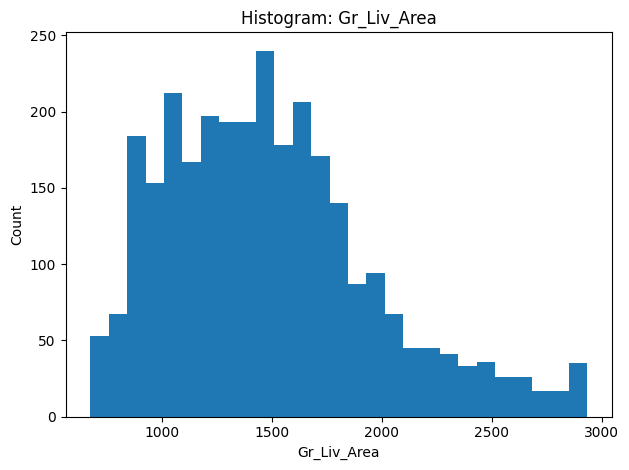

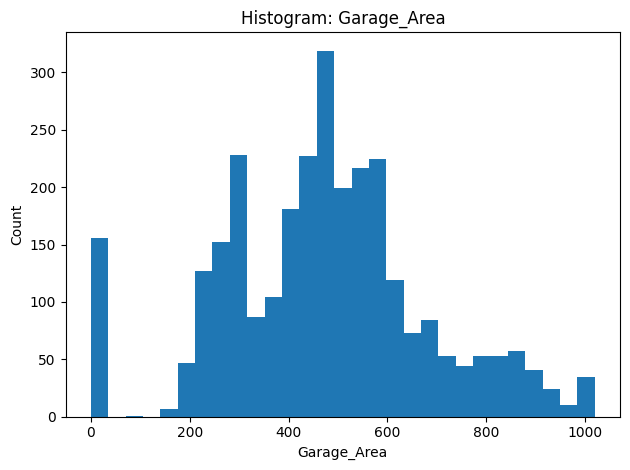

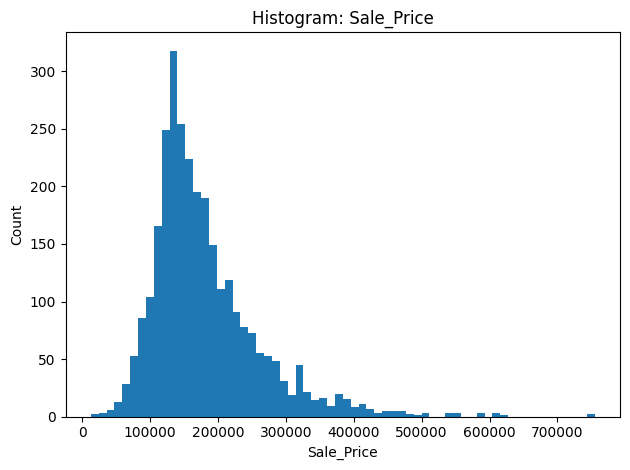

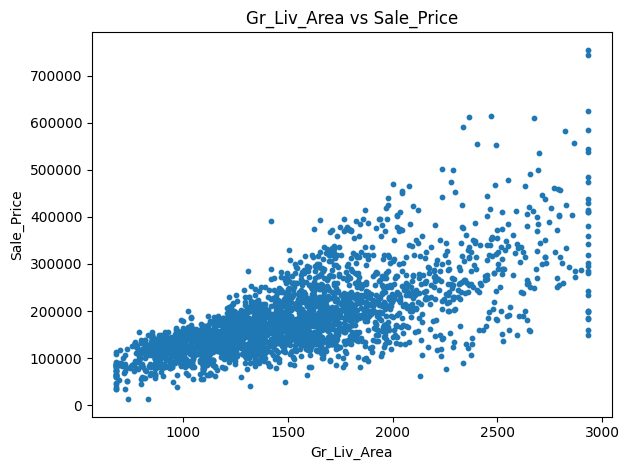

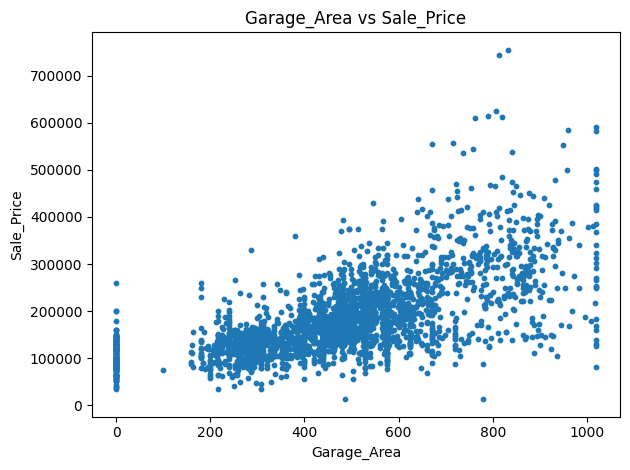

Correlation matrix (Pearson):
              Gr_Liv_Area  Garage_Area  Sale_Price
Gr_Liv_Area        1.000        0.484       0.714
Garage_Area        0.484        1.000       0.646
Sale_Price         0.714        0.646       1.000


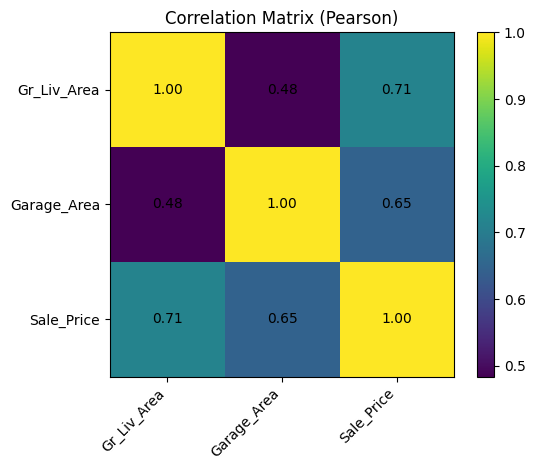

In [4]:
# Explore the data with visualisations such as histograms and correlation matrices

active_df = df_clean if "df_clean" in globals() else df

# Ensure expected column names exist 
aliases = {
    "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
    "Garage_Area": ["Garage_Area", "GarageArea"],
    "Sale_Price":  ["Sale_Price", "SalePrice"],
}
lower = {c.lower(): c for c in active_df.columns}
for canon, opts in aliases.items():
    found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
    if found is None:
        raise ValueError(f"Required column missing for EDA: any of {opts}")
    if found != canon:
        active_df[canon] = active_df[found]

cols = ["Gr_Liv_Area", "Garage_Area", "Sale_Price"]

# Histograms with defensive progamming
for c in cols:
    s = pd.to_numeric(active_df[c], errors="coerce").dropna()

    if s.empty:
        print(f"Skipping {c}: no numeric data after coercion.")
        continue

    fig = plt.figure()
# If the series has very few distinct values, show a bar of value counts instead of a histogram
    if s.nunique() <= 10:
        vc = s.value_counts().sort_index()
        plt.bar(vc.index.astype(float), vc.values, width=(
            (vc.index.max() - vc.index.min()) / max(len(vc), 1) if len(vc) > 1 else 0.8
        ))
        plt.title(f"Value Counts (few unique): {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
    else:
        plt.hist(s.values, bins="auto")
        plt.title(f"Histogram: {c}")
        plt.xlabel(c)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

# Scatter plots vs. Sale_Price
for feature in ["Gr_Liv_Area", "Garage_Area"]:
    pair = active_df[[feature, "Sale_Price"]].copy()
    pair[feature]     = pd.to_numeric(pair[feature], errors="coerce")
    pair["Sale_Price"] = pd.to_numeric(pair["Sale_Price"], errors="coerce")
    pair = pair.dropna()

    if pair.empty:
        print(f"Skipping scatter for {feature}: insufficient numeric data.")
        continue

    fig = plt.figure()
    plt.scatter(pair[feature], pair["Sale_Price"], s=10)
    plt.title(f"{feature} vs Sale_Price")
    plt.xlabel(feature)
    plt.ylabel("Sale_Price")
    plt.tight_layout()
    plt.show()

# Correlation matrix
eda_numeric = active_df[cols].apply(pd.to_numeric, errors="coerce")
corr = eda_numeric.corr(method="pearson")
print("Correlation matrix (Pearson):\n", corr.round(3))

fig = plt.figure()
im = plt.imshow(corr.values)
plt.title("Correlation Matrix (Pearson)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)

# annotate values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## Build model inputs (X, y)
Select the two predictors and the target, enforce consistent names, and produce clean feature/label arrays.

In [5]:
# Split the independent variables from the dependent variable
active_df = df_clean if "df_clean" in globals() else df

# Ensure expected column names exist (support common aliases)
aliases = {
    "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
    "Garage_Area": ["Garage_Area", "GarageArea"],
    "Sale_Price":  ["Sale_Price", "SalePrice"],
}
lower = {c.lower(): c for c in active_df.columns}
for canon, opts in aliases.items():
    found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
    if found is None:
        raise ValueError(f"Required column not found for modeling: any of {opts}")
    if found != canon:
        active_df[canon] = active_df[found]

# Define features/target
feature_cols = ["Gr_Liv_Area", "Garage_Area"]
target_col   = "Sale_Price"

# Build modeling frame and coerce to numeric
df_model = active_df[feature_cols + [target_col]].copy()
for c in feature_cols + [target_col]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# Drop rows with missing values in modeling columns
before = len(df_model)
df_model = df_model.dropna(subset=feature_cols + [target_col])
dropped = before - len(df_model)
if dropped > 0:
    print(f"Note: dropped {dropped} row(s) with missing values in {feature_cols + [target_col]}.")

# Final X/y
X = df_model[feature_cols].copy()   # keep as DataFrame to preserve column names
y = df_model[target_col].copy()     # Series

# Sanity checks / previews
print(f"X shape: {X.shape} | y shape: {y.shape}")
print("X dtypes:\n", X.dtypes)
display(X.head(5))
display(y.head(5))

X shape: (2923, 2) | y shape: (2923,)
X dtypes:
 Gr_Liv_Area    float64
Garage_Area    float64
dtype: object


,Gr_Liv_Area,Garage_Area
0,1656.0,528.0
1,896.0,730.0
2,1329.0,312.0
3,2110.0,522.0
4,1629.0,482.0


0    215000
1    105000
2    172000
3    244000
4    189900
Name: Sale_Price, dtype: int64

## Relationship plots
Visualise how each feature relates to the target, add a simple fit line, and sanity-check trends.

Gr_Liv_Area ↔ Sale_Price | Pearson r = 0.714, R^2 = 0.509


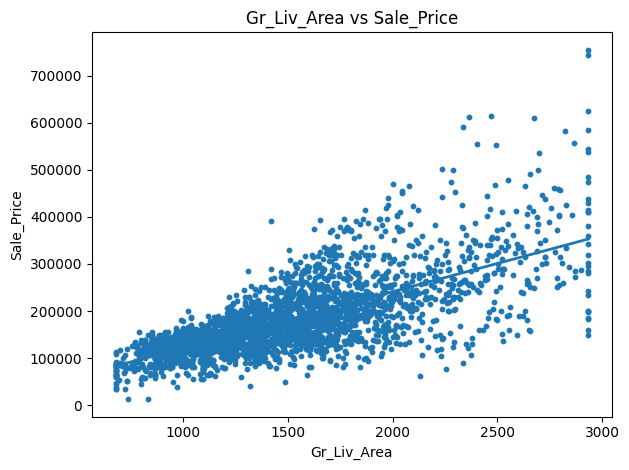

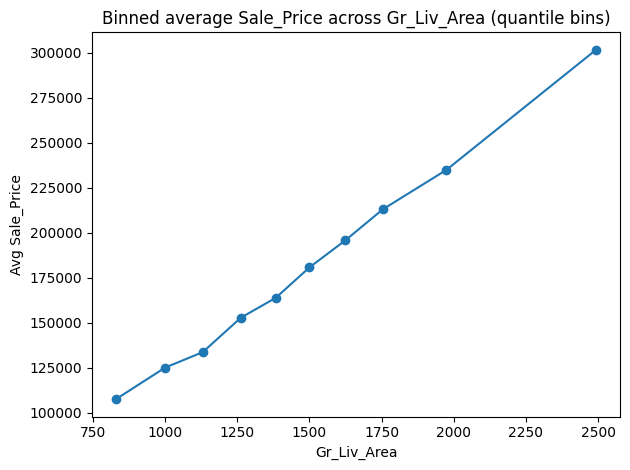

Garage_Area ↔ Sale_Price | Pearson r = 0.646, R^2 = 0.417


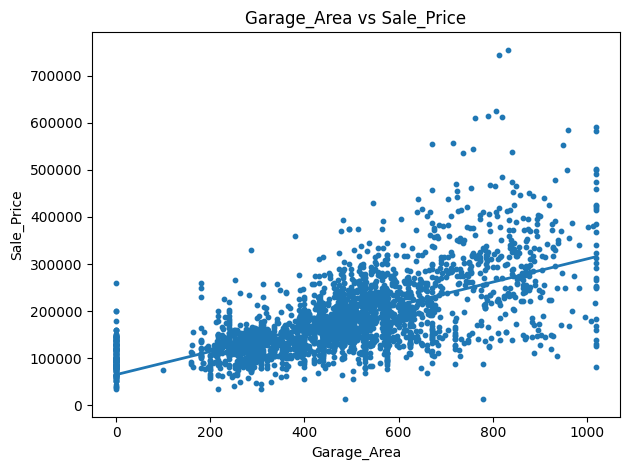

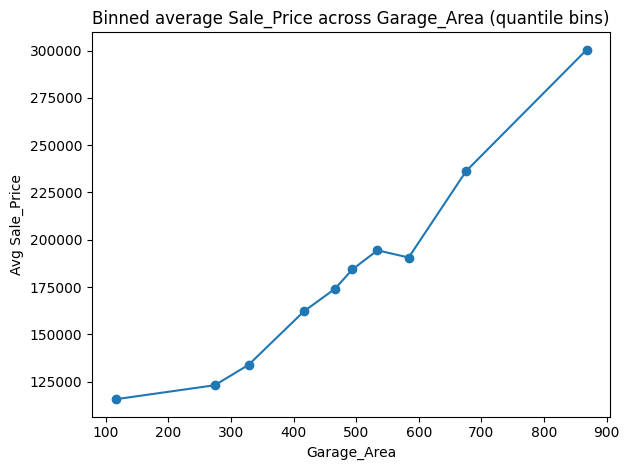

Gr_Liv_Area ↔ log(Sale_Price) | Pearson r = 0.711, R^2 = 0.505


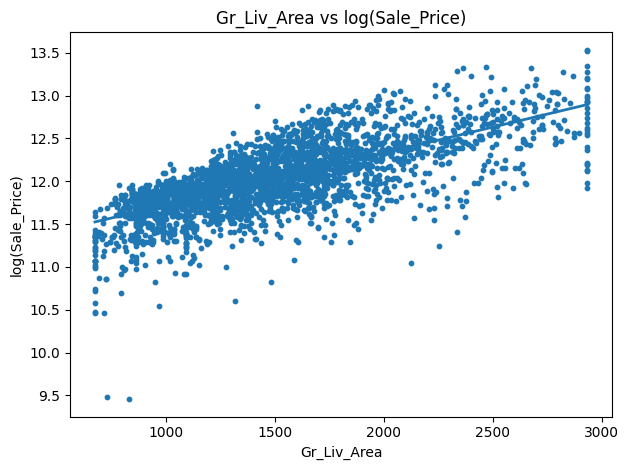

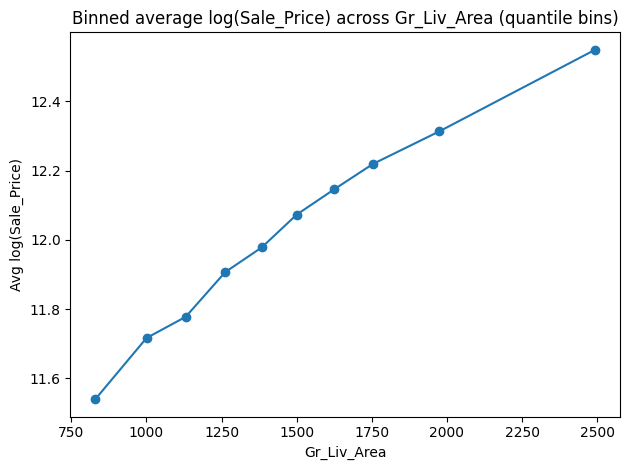

Garage_Area ↔ log(Sale_Price) | Pearson r = 0.659, R^2 = 0.434


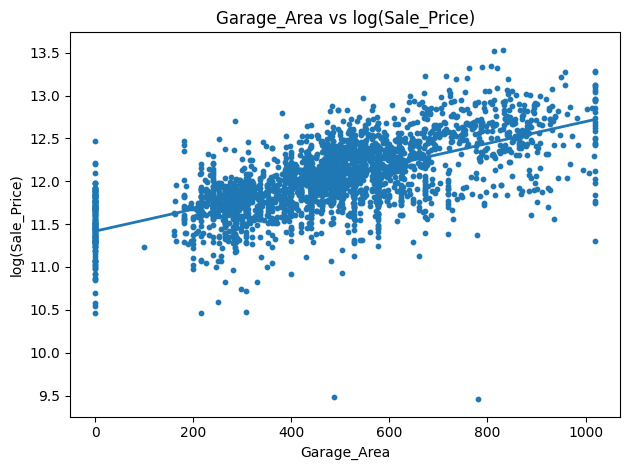

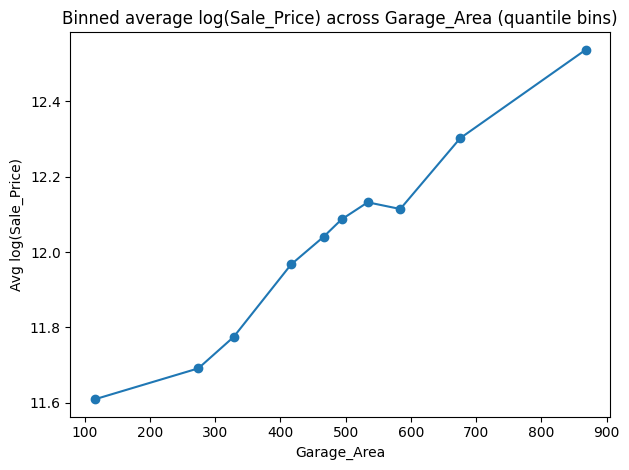

In [6]:
# Explore relationships between the independent and dependent variables
active_df = df_clean if "df_clean" in globals() else df

# Ensure expected columns exist 
aliases = {
    "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
    "Garage_Area": ["Garage_Area", "GarageArea"],
    "Sale_Price":  ["Sale_Price", "SalePrice"],
}
lower = {c.lower(): c for c in active_df.columns}
for canon, opts in aliases.items():
    found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
    if found is None:
        raise ValueError(f"Required column not found for relationship plots: any of {opts}")
    if found != canon:
        active_df[canon] = active_df[found]

feature_cols = ["Gr_Liv_Area", "Garage_Area"]
target_col   = "Sale_Price"

# Numeric-only modeling frame
rel = active_df[feature_cols + [target_col]].copy()
for c in rel.columns:
    rel[c] = pd.to_numeric(rel[c], errors="coerce")
rel = rel.dropna(subset=feature_cols + [target_col])

if rel.empty:
    raise ValueError("No data available for relationship plots after coercion and NA drop.")

def scatter_with_fit(x, y, x_label, y_label):
    """
    Make a scatter plot with a simple OLS fit line using numpy.polyfit,
    print Pearson r and R^2, and show binned means as a gentle trend check.
    """
    if len(x) < 3:
        print(f"Skipping {x_label}: not enough points ({len(x)})")
        return

    # Scatter
    fig = plt.figure()
    plt.scatter(x, y, s=10)
    plt.title(f"{x_label} vs {y_label}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Fit straight line
    try:
        a, b = np.polyfit(x, y, 1)
        xs = np.linspace(float(np.min(x)), float(np.max(x)), 200)
        ys = a * xs + b
        plt.plot(xs, ys, linewidth=2)  # default style/color
    except Exception as e:
        print(f"Fit line failed for {x_label}: {e}")

    # Pearson correlation
    try:
        r = np.corrcoef(x, y)[0, 1]
        r2 = r**2
        print(f"{x_label} ↔ {y_label} | Pearson r = {r:.3f}, R^2 = {r2:.3f}")
    except Exception as e:
        print(f"Correlation failed for {x_label}: {e}")

    plt.tight_layout()
    plt.show()

    # Binned means as a simple trend check
    try:
        bins = min(10, max(3, int(np.sqrt(len(x)))))  # ~√n bins, clipped to [3,10]
        q = pd.qcut(x, q=bins, duplicates="drop")
        grouped = pd.DataFrame({"x": x, "y": y, "bin": q}).groupby("bin", observed=True)
        x_mid = grouped["x"].mean()
        y_mean = grouped["y"].mean()

        fig = plt.figure()
        plt.plot(x_mid.values, y_mean.values, marker="o")
        plt.title(f"Binned average {y_label} across {x_label} (quantile bins)")
        plt.xlabel(x_label)
        plt.ylabel(f"Avg {y_label}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Binned trend failed for {x_label}: {e}")

# Linear scale relationships
for feat in feature_cols:
    x = rel[feat].values.astype(float)
    y = rel[target_col].values.astype(float)
    scatter_with_fit(x, y, feat, target_col)

#  log view - only if target > 0
if (rel[target_col] > 0).all():
    y_log = np.log(rel[target_col].values.astype(float))
    for feat in feature_cols:
        x = rel[feat].values.astype(float)
        scatter_with_fit(x, y_log, feat, f"log({target_col})")
else:
    print("Skipping log(Sale_Price): some values are non-positive.")

## Train/test split (75:25)
Prepare clean feature/target arrays, optionally preserve price distribution, and create reproducible splits.

In [7]:
# Create a training and test set with a 75:25 split ratio
feature_names = feature_cols if "feature_cols" in globals() else None

def as_frame(X, feature_names=None):
    """Return X as a DataFrame with sensible column names."""
    if isinstance(X, pd.DataFrame):
        return X.copy()
    X_arr = np.asarray(X)
    cols = feature_names if (feature_names is not None and len(feature_names) == X_arr.shape[1]) \
           else [f"x{i}" for i in range(X_arr.shape[1])]
    return pd.DataFrame(X_arr, columns=cols)

def as_series(y, name="Sale_Price"):
    """Return y as a Series with a stable name."""
    if isinstance(y, pd.Series):
        return y.copy()
    y_arr = np.asarray(y).reshape(-1)
    return pd.Series(y_arr, name=name)

# Standardize X/y to pandas
X_df = as_frame(X, feature_names)
y_sr = as_series(y, name="Sale_Price")

# Drop rows with any NaNs across modeling columns
model_df = X_df.join(y_sr)
before = len(model_df)
model_df = model_df.dropna()
dropped = before - len(model_df)
if dropped:
    print(f"Note: dropped {dropped} row(s) with NaNs across features/target before split.")

X_clean = model_df.drop(columns=[y_sr.name])
y_clean = model_df[y_sr.name]

# stratify on target quantiles to preserve price distribution
stratify_labels = None
try:
    bins = min(10, max(3, int(np.sqrt(len(y_clean)))))  
    qbins = pd.qcut(y_clean, q=bins, duplicates="drop")
    if qbins.nunique() >= 3:
        stratify_labels = qbins
except Exception:
    stratify_labels = None  

# 75:25 split 
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=stratify_labels
)

# Tidy indices
X_train = X_train.reset_index(drop=True); X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True); y_test = y_test.reset_index(drop=True)

print(f"Shapes -> X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
print("Train target summary:", y_train.describe()[["mean","50%","min","max"]].to_dict())
print("Test  target summary:", y_test.describe()[["mean","50%","min","max"]].to_dict())

Note: dropped 7 row(s) with NaNs across features/target before split.
Shapes -> X_train:(2187, 2), X_test:(729, 2), y_train:(2187,), y_test:(729,)
Train target summary: {'mean': 180310.43484224967, '50%': 160000.0, 'min': 13100.0, 'max': 615000.0}
Test  target summary: {'mean': 181910.4307270233, '50%': 160000.0, 'min': 12789.0, 'max': 755000.0}


## Fit the simple regression
I train LinearRegression on Gr_Liv_Area and Garage_Area. Inputs/target are coerced to numeric, rows with missing values are dropped, and I report the intercept plus per-sq-ft coefficients.


In [8]:
# Build a multiple linear regression model using 'Gr_Liv_Area' and 'Garage_Area'


if not all(k in globals() for k in ["X_train", "X_test", "y_train", "y_test"]):
    raise RuntimeError("Train/test data not found. Run the split cell first.")

# Ensure expected feature names exist (support common aliases)
def ensure_feature_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    aliases = {
        "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
        "Garage_Area": ["Garage_Area", "GarageArea"],
    }
    lower = {c.lower(): c for c in df.columns}
    for canon, opts in aliases.items():
        found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
        if found is None:
            raise ValueError(f"Required feature not found: any of {opts}")
        if found != canon:
            df[canon] = df[found]
    return df

X_train_named = ensure_feature_names(X_train)
X_test_named  = ensure_feature_names(X_test)

feature_cols = ["Gr_Liv_Area", "Garage_Area"]

# Coerce training features to numeric and align with y
train_df = X_train_named[feature_cols].copy()
for c in feature_cols:
    train_df[c] = pd.to_numeric(train_df[c], errors="coerce")

train_df["Sale_Price"] = pd.to_numeric(y_train, errors="coerce")
before = len(train_df)
train_df = train_df.dropna(subset=feature_cols + ["Sale_Price"])
dropped = before - len(train_df)
if dropped:
    print(f"Note: dropped {dropped} training row(s) with NaNs in features/target.")

Xtr = train_df[feature_cols]
ytr = train_df["Sale_Price"]

# Fit the model
linreg = LinearRegression()
linreg.fit(Xtr, ytr)

# Report parameters (clear & labeled)
coef_tbl = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": linreg.coef_.astype(float)
})
print(f"Intercept: {float(linreg.intercept_):,.4f}")
display(coef_tbl)

# Quality on training data
r2_train = linreg.score(Xtr, ytr)
print(f"Train R^2: {r2_train:.3f}")

# Prepare clean test features 
Xte = X_test_named[feature_cols].copy()
for c in feature_cols:
    Xte[c] = pd.to_numeric(Xte[c], errors="coerce")
mask = Xte.notna().all(axis=1) & pd.to_numeric(y_test, errors="coerce").notna()

X_te = Xte.loc[mask].reset_index(drop=True)
y_te = pd.to_numeric(y_test, errors="coerce").loc[mask].reset_index(drop=True)

y_pred_test = linreg.predict(X_te)  # ready for evaluation step
print(f"Prepared {len(y_pred_test)} test predictions in `y_pred_test`.")

Intercept: 73,006.0057


,feature,coefficient
0,Gr_Liv_Area,37.474583
1,Garage_Area,107.450989


Train R^2: 0.202
Prepared 729 test predictions in `y_pred_test`.


## Report model parameters
Print a clean summary of the fitted linear model.

In [9]:
# Print the model intercept and coefficients

# Ensure the model exists and is fitted
if "linreg" not in globals() or not hasattr(linreg, "coef_"):
    raise RuntimeError("Model 'linreg' not found or not fitted. Run the training cell first.")

# Resolve feature names from context (falls back to generic names)
def _feature_names():
    if "feature_cols" in globals() and isinstance(feature_cols, (list, tuple)) \
       and len(feature_cols) == len(np.ravel(linreg.coef_)):
        return list(feature_cols)
    if "Xtr" in globals() and hasattr(Xtr, "columns") \
       and len(Xtr.columns) == len(np.ravel(linreg.coef_)):
        return list(Xtr.columns)
    if "X_train" in globals():
        try:
            X_arr = np.asarray(X_train)
            cols = [f"x{i}" for i in range(X_arr.shape[1])]
            if isinstance(X_train, pd.DataFrame):
                cols = list(X_train.columns)
            return cols[: len(np.ravel(linreg.coef_))]
        except Exception:
            pass
    return [f"feature_{i}" for i in range(len(np.ravel(linreg.coef_)))]

names = _feature_names()

# Extract parameters and present cleanly
intercept = float(np.ravel(linreg.intercept_)[0] if np.ndim(linreg.intercept_) else linreg.intercept_)
coefs = np.ravel(linreg.coef_).astype(float)

params = pd.DataFrame({"feature": names, "coefficient": coefs})
print(f"Intercept: {intercept:,.4f}")
display(params)

# show a readable equation if the standard names are present
if {"Gr_Liv_Area", "Garage_Area"}.issubset(set(names)):
    b = dict(zip(names, coefs))
    print("\nModel equation:")
    print(
        f"Sale_Price = {intercept:,.2f} "
        f"+ {b['Gr_Liv_Area']:,.2f}*Gr_Liv_Area "
        f"+ {b['Garage_Area']:,.2f}*Garage_Area"
    )

Intercept: 73,006.0057


,feature,coefficient
0,Gr_Liv_Area,37.474583
1,Garage_Area,107.450989



Model equation:
Sale_Price = 73,006.01 + 37.47*Gr_Liv_Area + 107.45*Garage_Area


## Test-set predictions 
Prepare clean test features/targets and generate out-of-sample predictions.

In [10]:
# Generate predictions for the test set
# Preconditions
if "linreg" not in globals() or not hasattr(linreg, "coef_"):
    raise RuntimeError("Model 'linreg' not found or not fitted. Run the training cell first.")
if "X_test" not in globals() or "y_test" not in globals():
    raise RuntimeError("X_test / y_test not found. Run the train/test split first.")

# Helpers to normalize inputs
def as_frame(X):
    """Return X as a DataFrame with generic names if needed."""
    if isinstance(X, pd.DataFrame):
        return X.copy()
    arr = np.asarray(X)
    return pd.DataFrame(arr, columns=[f"x{i}" for i in range(arr.shape[1])])

def ensure_features(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure presence of Gr_Liv_Area and Garage_Area (handles common aliases)."""
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    aliases = {
        "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
        "Garage_Area": ["Garage_Area", "GarageArea"],
    }
    lower = {c.lower(): c for c in df.columns}
    for canon, opts in aliases.items():
        found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
        if found is None:
            raise ValueError(f"Required feature missing in X_test: any of {opts}")
        if found != canon:
            df[canon] = df[found]
# Keep only the two features, coerced to numeric
    for c in ["Gr_Liv_Area", "Garage_Area"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df[["Gr_Liv_Area", "Garage_Area"]]

# Build clean test features/target
Xte_raw = as_frame(X_test)
X_te = ensure_features(Xte_raw)

y_te = pd.Series(np.asarray(y_test).reshape(-1), name="Sale_Price")
y_te = pd.to_numeric(y_te, errors="coerce")

# Drop any rows with NaNs in features/target to avoid prediction errors
mask = X_te.notna().all(axis=1) & y_te.notna()
X_te = X_te.loc[mask].reset_index(drop=True)
y_te = y_te.loc[mask].reset_index(drop=True)

# Predict
y_pred_test = pd.Series(linreg.predict(X_te), name="Predicted")

# Small preview 
preview = pd.DataFrame({
    "Gr_Liv_Area": X_te["Gr_Liv_Area"],
    "Garage_Area": X_te["Garage_Area"],
    "Actual": y_te,
    "Predicted": y_pred_test,
    "Error": y_pred_test - y_te
})
print(f"Generated {len(preview)} test predictions.")
display(preview.head(5))

Generated 729 test predictions.


,Gr_Liv_Area,Garage_Area,Actual,Predicted,Error
0,1993.0,495.0,157500.0,200881.089949,43381.089949
1,1588.0,472.0,157500.0,183232.510956,25732.510956
2,1128.0,528.0,68400.0,172011.458046,103611.458046
3,2331.0,1003.0,412500.0,268132.601728,-144367.398272
4,884.0,270.0,117000.0,135145.304452,18145.304452


## Evaluate model performance 
Compute core error metrics, compare to a simple baseline, and run quick diagnostic plots.

,Model,MAE,MSE,RMSE,R2
0,LinearRegression,50360.460,5.500835e+09,74167.617,0.211
1,Baseline(mean(train)),59143.102,6.971982e+09,83498.397,-0.000


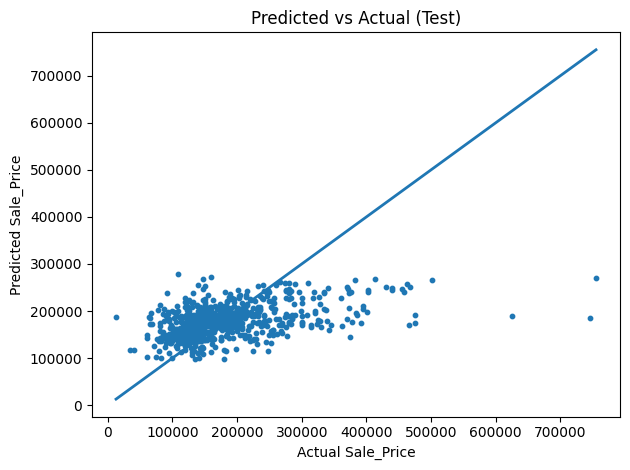

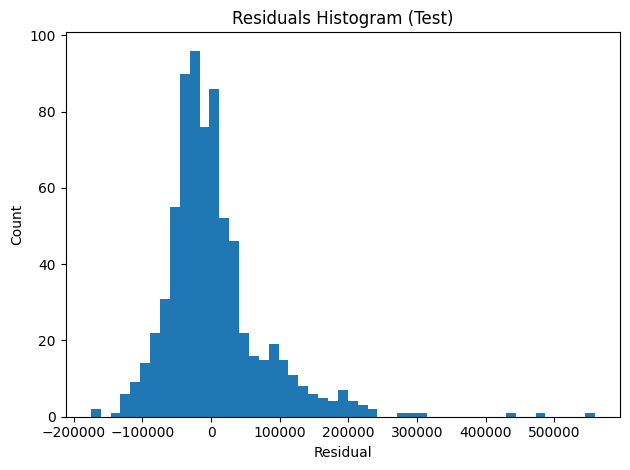

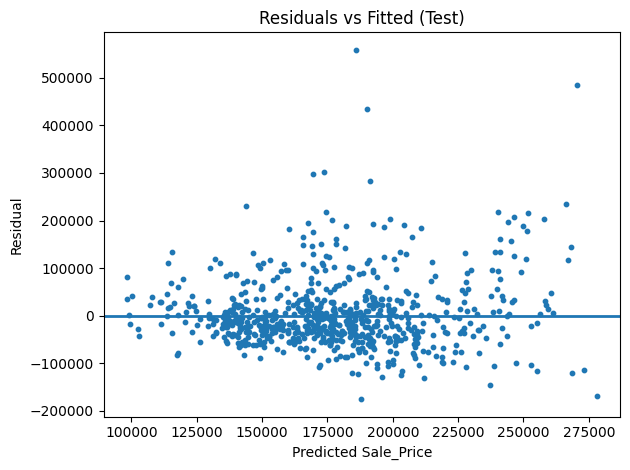

In [11]:
# Evaluate the model
if "linreg" not in globals() or not hasattr(linreg, "coef_"):
    raise RuntimeError("Model 'linreg' not found or not fitted. Run the training cell first.")
if "X_test" not in globals() or "y_test" not in globals():
    raise RuntimeError("X_test / y_test not found. Run the train/test split first.")

# Build clean test set 
def _as_frame(X):
    if isinstance(X, pd.DataFrame):
        return X.copy()
    X = np.asarray(X)
    return pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])

def _ensure_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    aliases = {
        "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
        "Garage_Area": ["Garage_Area", "GarageArea"],
    }
    lower = {c.lower(): c for c in df.columns}
    for canon, opts in aliases.items():
        found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
        if found is None:
            raise ValueError(f"Required feature missing in X_test: any of {opts}")
        if found != canon:
            df[canon] = df[found]
    for c in ["Gr_Liv_Area", "Garage_Area"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df[["Gr_Liv_Area", "Garage_Area"]]

if "y_pred_test" in globals() and "y_te" in globals():
    y_true = pd.to_numeric(pd.Series(y_te).rename("Actual"), errors="coerce")
    y_pred = pd.to_numeric(pd.Series(y_pred_test).rename("Predicted"), errors="coerce")
    mask = y_true.notna() & y_pred.notna()
    y_true = y_true[mask].reset_index(drop=True)
    y_pred = y_pred[mask].reset_index(drop=True)
else:
    Xte_raw = _as_frame(X_test)
    X_te = _ensure_features(Xte_raw)
    y_te = pd.Series(np.asarray(y_test).reshape(-1), name="Actual")
    y_te = pd.to_numeric(y_te, errors="coerce")
    mask = X_te.notna().all(axis=1) & y_te.notna()
    X_te = X_te.loc[mask].reset_index(drop=True)
    y_true = y_te.loc[mask].reset_index(drop=True)
    y_pred = pd.Series(linreg.predict(X_te), name="Predicted")

if len(y_true) == 0:
    raise ValueError("No valid test rows to evaluate after cleaning.")

# Metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)

# predict the training mean
baseline_row = {}
if "y_train" in globals():
    y_train_arr = np.asarray(y_train).reshape(-1)          # <-- fixed reshape
    y_train_clean = pd.to_numeric(pd.Series(y_train_arr), errors="coerce").dropna()
    if len(y_train_clean) > 0:
        base_val = float(y_train_clean.mean())
        y_base = pd.Series(base_val, index=y_true.index)
        baseline_row = {
            "Model": "Baseline(mean(train))",
            "MAE": mean_absolute_error(y_true, y_base),
            "MSE": mean_squared_error(y_true, y_base),
            "RMSE": float(np.sqrt(mean_squared_error(y_true, y_base))),
            "R2": r2_score(y_true, y_base),
        }

# Report
rows = [{"Model": "LinearRegression", "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}]
if baseline_row:
    rows.append(baseline_row)
report = pd.DataFrame(rows)
display(report.round(3))

# Diagnostics
residuals = (y_true - y_pred).rename("Residual")

# Predicted vs Actual
fig = plt.figure()
plt.scatter(y_true, y_pred, s=10)
mn = float(min(y_true.min(), y_pred.min()))
mx = float(max(y_true.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], linewidth=2)  # 45° line
plt.title("Predicted vs Actual (Test)")
plt.xlabel("Actual Sale_Price")
plt.ylabel("Predicted Sale_Price")
plt.tight_layout()
plt.show()

# Residuals histogram
fig = plt.figure()
plt.hist(residuals, bins="auto")
plt.title("Residuals Histogram (Test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Residuals vs Fitted
fig = plt.figure()
plt.scatter(y_pred, residuals, s=10)
plt.axhline(0, linewidth=2)
plt.title("Residuals vs Fitted (Test)")
plt.xlabel("Predicted Sale_Price")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

## Predicted vs Actual 
Plot test predictions against the true prices with a 45° reference line and display R².


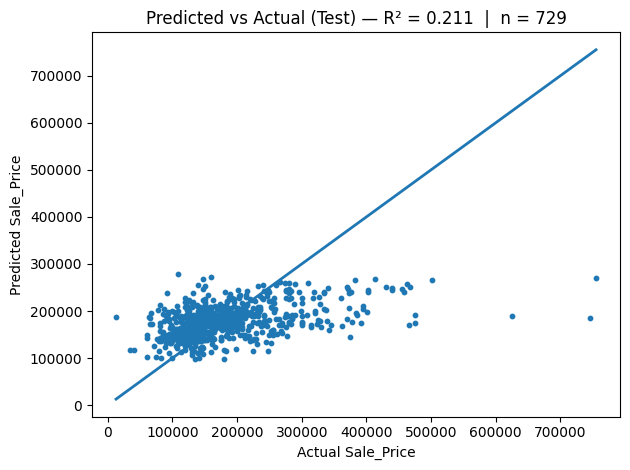

In [12]:
# Generate a plot


# Preconditions
if "linreg" not in globals() or not hasattr(linreg, "coef_"):
    raise RuntimeError("Model 'linreg' not found or not fitted.")
if "X_test" not in globals() or "y_test" not in globals():
    raise RuntimeError("X_test / y_test not found. Run the split first.")

# Build/reuse y_true, y_pred safely
def _as_frame(X):
    if isinstance(X, pd.DataFrame):
        return X.copy()
    X = np.asarray(X)
    return pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])

def _ensure_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    aliases = {
        "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
        "Garage_Area": ["Garage_Area", "GarageArea"],
    }
    lower = {c.lower(): c for c in df.columns}
    for canon, opts in aliases.items():
        found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
        if found is None:
            raise ValueError(f"Required feature missing in X_test: any of {opts}")
        if found != canon:
            df[canon] = df[found]
    for c in ["Gr_Liv_Area", "Garage_Area"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df[["Gr_Liv_Area", "Garage_Area"]]

if "y_pred_test" in globals() and "y_te" in globals():
    y_true = pd.to_numeric(pd.Series(y_te), errors="coerce")
    y_pred = pd.to_numeric(pd.Series(y_pred_test), errors="coerce")
    mask = y_true.notna() & y_pred.notna()
    y_true, y_pred = y_true[mask].reset_index(drop=True), y_pred[mask].reset_index(drop=True)
else:
    Xte_raw = _as_frame(X_test)
    X_te = _ensure_features(Xte_raw)
    y_te = pd.Series(np.asarray(y_test).reshape(-1))
    y_te = pd.to_numeric(y_te, errors="coerce")
    mask = X_te.notna().all(axis=1) & y_te.notna()
    X_te = X_te.loc[mask].reset_index(drop=True)
    y_true = y_te.loc[mask].reset_index(drop=True)
    y_pred = pd.Series(linreg.predict(X_te))

if len(y_true) == 0:
    raise ValueError("No valid test rows to plot after cleaning.")

# Compute R² for the title
r2 = r2_score(y_true, y_pred)

# Predicted vs Actual with 45° reference
fig = plt.figure()
plt.scatter(y_true, y_pred, s=10)
mn, mx = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], linewidth=2)  # 45° line
plt.title(f"Predicted vs Actual (Test) — R² = {r2:.3f}  |  n = {len(y_true)}")
plt.xlabel("Actual Sale_Price")
plt.ylabel("Predicted Sale_Price")
plt.tight_layout()
plt.show()


## Coefficients
Report the linear model’s feature weights; if no fitted model is available, train a quick one first.

In [13]:
# Print the coefficients

def _normalize_headers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    return df

def _ensure_expected_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Map common Ames aliases to canonical names we will use."""
    df = _normalize_headers(df)
    aliases = {
        "Gr_Liv_Area": ["Gr_Liv_Area", "GrLivArea"],
        "Garage_Area": ["Garage_Area", "GarageArea"],
        "Sale_Price":  ["Sale_Price", "SalePrice"],
    }
    lower = {c.lower(): c for c in df.columns}
    for canon, opts in aliases.items():
        found = next((lower[o.lower()] for o in opts if o.lower() in lower), None)
        if found is None:
            raise ValueError(f"Required column not found (any of {opts})")
        if found != canon:
            df[canon] = df[found]
    return df

# Ensure a fitted model exists 
feature_cols = ["Gr_Liv_Area", "Garage_Area"]
target_col   = "Sale_Price"

if "linreg" not in globals() or not hasattr(linreg, "coef_"):
    if "df_clean" in globals():
        source = df_clean.copy()
    elif "df" in globals():
        source = df.copy()
    else:
        raise RuntimeError("No model found and no DataFrame (df/df_clean) to train from.")

    source = _ensure_expected_columns(source)

 # Build modeling frame
    model_df = source[feature_cols + [target_col]].copy()
    for c in model_df.columns:
        model_df[c] = pd.to_numeric(model_df[c], errors="coerce")
    model_df = model_df.dropna()
    if len(model_df) < 3:
        raise RuntimeError("Not enough rows to fit a model after cleaning.")

 # Use existing split if available; else create a quick 75:25 split
    if all(k in globals() for k in ["X_train", "y_train"]):
        Xtr = pd.DataFrame(X_train, columns=getattr(X_train, "columns", None))
        Xtr = _ensure_expected_columns(Xtr)
        Xtr = Xtr[feature_cols].apply(pd.to_numeric, errors="coerce")
        ytr = pd.to_numeric(pd.Series(y_train).reshape(-1), errors="coerce")
        mask = Xtr.notna().all(axis=1) & ytr.notna()
        Xtr, ytr = Xtr.loc[mask], ytr.loc[mask]
    else:
        X = model_df[feature_cols]
        y = model_df[target_col]
        Xtr, _, ytr, _ = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    linreg = LinearRegression().fit(Xtr, ytr)

# Print coefficients with no intercept
names = feature_cols  
coefs = np.ravel(linreg.coef_).astype(float)
coef_table = pd.DataFrame({"feature": names, "coefficient": coefs})

coef_table["coef_per_100_units"] = coef_table["coefficient"] * 100.0

display(coef_table.round(4))

 


,feature,coefficient,coef_per_100_units
0,Gr_Liv_Area,37.4746,3747.4583
1,Garage_Area,107.4510,10745.0989


**Interpret coefficients in the context of the prediction:**

## How to read the numbers

Gr_Liv_Area coefficient: expected change in price for +1 sq ft of living space (garage held the same). A quick mental shortcut is to multiply the coefficient by 100 for “per extra 100 sq ft.”

Garage_Area coefficient: same idea, but for garage space.
Intercept: just the model’s reference level; don’t treat a “zero-size house” literally.

**Summarise findings**

## What I learned
Living area is the main linear driver in this two-feature setup.

Garage size helps, but less than living space.

Two size features can’t explain all price variation; adding quality/location-type variables would likely improve the fit.